In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
from folium import plugins
import matplotlib.pyplot as plt
from shapely.geometry import Point
import plotly.express as px
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score
from pyproj import Proj
import geopandas as gpd

%matplotlib inline
plt.style.use('seaborn-pastel')
sns.set(style="whitegrid")
sns.set_context("talk")

## 1) Classification with Feed Forward Neural Network

### Prepare data
- pre-select columns for classification based on previous analysis
- normalize columns

In [14]:
data = pd.read_csv("CLEAN_HOUSEHOLD_DATASET (1).csv")

In [15]:
data.head()

,Unnamed: 0,Hogar,Sector,DirCoordX,DirCoordY,MontoArr,IngresoHogar,Factor,AnosEstudio,CLASE,Sup_Prom_Constr_Hab_EOD,Calid_EOD_norm_inv,DensConstr_EOD,Dist_est_Metro_MC_KM,Dist_salida_Autop_MC_KM,Tiempo_Com_Stgo,Ingreso_Promedio_Zona_MM,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto,geometry,index_right,ID,Com,Comuna,AREA-Ha,Excluir,Lat,Lon
0,0,100010,7,335180.8019,6266420.975,0.018036,0.030462,0.142347,0.458333,1.0,0.259527,0.98,0.012829,23.051711,4.345179,69.0,0.519765,0.108886,0.122324,0.128953,0.14158,0.086636,0.263845,0.287228,0.302676,0.292559,0.223374,POINT (335180.8019 6266420.975),829,786.0,13402,Buin,965.98,0,-33.729444,-70.779034
1,7,100082,7,338923.4993,6266488.784,0.026052,0.005347,0.118778,0.458333,1.0,0.259527,0.98,0.012829,20.104986,0.606194,69.0,0.519765,0.108886,0.122324,0.128953,0.14158,0.086636,0.263845,0.287228,0.302676,0.292559,0.223374,POINT (338923.4993 6266488.784),829,786.0,13402,Buin,965.98,0,-33.729408,-70.738640
2,9,100102,7,334850.7817,6266124.316,0.025791,0.104316,0.112571,0.583333,2.0,0.259527,0.98,0.012829,23.493233,4.684653,69.0,0.519765,0.108886,0.122324,0.128953,0.14158,0.086636,0.263845,0.287228,0.302676,0.292559,0.223374,POINT (334850.7817 6266124.316000001),829,786.0,13402,Buin,965.98,0,-33.732067,-70.782650
3,10,100112,7,335866.8423,6266308.101,0.028056,0.018787,0.145717,0.416667,1.0,0.259527,0.98,0.012829,22.569740,3.660904,69.0,0.519765,0.108886,0.122324,0.128953,0.14158,0.086636,0.263845,0.287228,0.302676,0.292559,0.223374,POINT (335866.8423 6266308.101),829,786.0,13402,Buin,965.98,0,-33.730568,-70.771653
4,12,100161,7,338124.9988,6266113.566,0.020552,0.006267,0.118778,0.500000,2.0,0.259527,0.98,0.012829,20.949755,1.434487,69.0,0.519765,0.108886,0.122324,0.128953,0.14158,0.086636,0.263845,0.287228,0.302676,0.292559,0.223374,POINT (338124.9988 6266113.566000001),829,786.0,13402,Buin,965.98,0,-33.732669,-70.747324


In [3]:
classification_columns_all = ['MontoArr','IngresoHogar','AnosEstudio','Factor','Sup_Prom_Constr_Hab_EOD',
                              'Calid_EOD_norm_inv','DensConstr_EOD','Dist_est_Metro_MC_KM','Dist_salida_Autop_MC_KM',
                              'Tiempo_Com_Stgo','Ingreso_Promedio_Zona_MM','Acc_Comercio_tpte_pub', 'Com']
target = 'CLASE'

In [4]:
def normalizeColumns(data, col):
    a =(data[col]-data[col].min())/(data[col].max()-data[col].min())
    data[col] = a

#NORMALIZE columns
normalizeColumns(data,classification_columns_all)

### Feature selection using RFE
Select subset of most important features using recursive feature elimination. This function calculates importance of smaller and smaller subsets of features and prunes unimportant features until selected number of features remains.
I've used logistic regression to estimate the importance.

In [5]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = data[classification_columns_all]
Y = data['CLASE']

rfe_selector = RFE(estimator=LogisticRegression(), n_features_to_select=4, step=10, verbose=5)
rfe_selector.fit(X, Y)
rfe_support = rfe_selector.get_support()
rfe_feature = X.loc[:,rfe_support].columns.tolist()

print(str(len(rfe_feature)), 'selected features')
print(rfe_feature)

Fitting estimator with 13 features.


/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



4 selected features
['MontoArr', 'IngresoHogar', 'AnosEstudio', 'Ingreso_Promedio_Zona_MM']


/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



### Split dataset
- train test validation data split
- one-hot encode target columns

In [6]:
#Train test split
data_test = data.loc[((data['Lat'] <= -33.4) & (data['Lat'] >= -33.5) & (data['Lon'] <= -70.6) & (data['Lon'] >= -70.7))]
data_train = data.drop(data_test.index)

X_train = data_train[rfe_feature]
X_test = data_test[rfe_feature]

#one-hot encoding targets
targets = data_test[target].reset_index()
targets['CLASE'] = pd.Categorical(targets['CLASE'])
y_test = pd.get_dummies(targets['CLASE'])

targets = data_train[target].reset_index()
targets['CLASE'] = pd.Categorical(targets['CLASE'])
y_train = pd.get_dummies(targets['CLASE'])

In [7]:
y_test.head()

,1.0,2.0,3.0
0,0,1,0
1,0,1,0
2,0,1,0
3,1,0,0
4,0,1,0


In [8]:
X_test.head()

,MontoArr,IngresoHogar,AnosEstudio,Ingreso_Promedio_Zona_MM
576,0.026052,0.029054,0.625,0.037649
577,0.022044,0.025000,0.500,0.037649
578,0.028056,0.020270,0.500,0.037649
579,0.024048,0.014485,0.250,0.037649
1671,0.024048,0.081757,0.500,0.122492


In [9]:
#validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=1)

print("Test:")
print(X_test.shape)
print("Train:")
print(X_train.shape)
print("Validation:")
print(X_val.shape)

Test:
(2924, 4)
Train:
(12659, 4)
Validation:
(2235, 4)


### Neural network model

In [10]:
from keras.models import Sequential
from keras.layers import Dense, Dropout,Activation
from keras.initializers import glorot_normal
from keras.optimizers import Adam
from keras.layers import BatchNormalization

Using TensorFlow backend.


In [11]:
input_shape = X_test.shape[1]
L1_hidden_n = 64
L2_hidden_n = 42
class_num = 3
act_f = 'relu'
glorot = glorot_normal(seed=42)

#define layers
m1 = Sequential()
#l1
m1.add(Dense(L1_hidden_n, use_bias=False,input_shape=(input_shape,),kernel_initializer=glorot))
m1.add(Activation(act_f))
m1.add(BatchNormalization(momentum=0.3))

#l2
m1.add(Dense(L2_hidden_n, use_bias=False,kernel_initializer=glorot))
m1.add(Activation(act_f))
m1.add(BatchNormalization(momentum=0.3))

#output layer
m1.add(Dense(class_num, activation='softmax',use_bias=True,kernel_initializer=glorot))

#optimizer
optimizer = Adam(lr=0.0005)
             
#compile model
m1.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
m1.summary()







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                256       
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
dense_2 (Dense)              (None, 42)                2688      
_________________________________________________________________
activation_2 (Activation)    (None, 42)                0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 42)                168       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 129       
Tota

In [12]:
batch_size = 100
epochs = 50

history = m1.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=0,
                    validation_data=(X_val, y_val))

score = m1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Test loss: 0.025286209686734444
Test accuracy: 0.9993160054719562


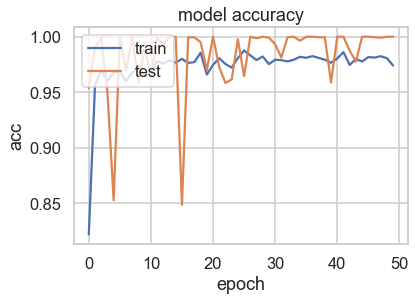

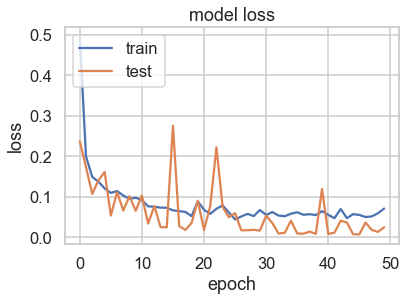

In [13]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [15]:
#history.history

### Confusion matrix

In [14]:
Y_pred = m1.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)
y_orig = np.argmax(y_test.values, axis=1)
cm = confusion_matrix(y_orig, y_pred)

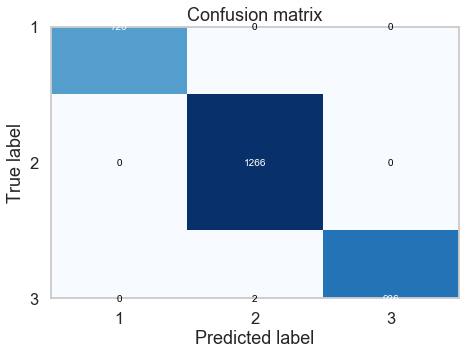

In [15]:
fig, ax = plt.subplots(figsize=(10,5))
classes = [1,2,3]
im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

ax.set(xticks=np.arange(cm.shape[1]),
       yticks=np.arange(cm.shape[0]),
       xticklabels=classes, yticklabels=classes,
       title='Confusion matrix',
       ylabel='True label',
       xlabel='Predicted label')
ax.grid(False)

thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, format(cm[i, j], 'd'),
                ha="center", va="center",
                color="white" if cm[i, j] > thresh else "black")

### FFNN classification summary

**Net Architecture**  
I've built a fully connected neural network with 2 hidden layers with 64 and 42 hidden units respectively and used ADAM optimizer for learning the weights. I've used batch normalization to improve the performance.


**Feature Selection**     
I've experimented with feature selection to find the lowest number of features that enable to reach 
over 99% accuracy in classification.

In the end the **best accuracy 99.96%** was achieved with these 4 features: 
- 'MontoArr' = Monthly dwelling rent
- 'IngresoHogar' = Household income
- 'AnosEstudio' = Years of formal Education of head of household
- 'Ingreso_Promedio_Zona_MM' = Average Zonal income

The type of household which buys a property seems to be dependent on 2 "external" factors: the rent and average income in the area. And two "household" factors: the income and education level, which are correlated.     
In the previous analysis we've noticed that there are distinct high income and low income areas in Santiago, therefore it makes sense that households rent a property in an area which matches their income level.

## 

### Splitting Test at Train set into K-folds

In [16]:
pd.set_option('display.max_rows', X_train.shape[0]+1)

In [17]:
X_train.T

,10810,6673,13185,8733,254,10345,1834,2591,10425,7509,...,144,5508,3347,8381,12317,909,5644,13534,235,14999
MontoArr,0.022044,0.198397,0.038076,0.028056,0.022044,0.012024,0.022044,0.014028,0.028056,0.018036,...,0.014028,0.018036,0.028056,0.022044,0.014028,0.018036,0.012024,0.028056,0.018036,0.012024
IngresoHogar,0.009699,0.097328,0.010831,0.015541,0.045270,0.032562,0.053390,0.034459,0.043919,0.055214,...,0.032329,0.025000,0.025592,0.020946,0.025175,0.033784,0.021752,0.060811,0.015089,0.010135
AnosEstudio,0.458333,0.791667,0.708333,0.500000,0.375000,0.458333,0.583333,0.500000,0.458333,0.583333,...,0.375000,0.500000,0.500000,0.500000,0.500000,0.500000,0.500000,0.583333,0.416667,0.250000
Ingreso_Promedio_Zona_MM,0.088440,0.298622,0.140972,0.110202,0.068858,0.074026,0.068201,0.079047,0.077941,0.052904,...,0.072900,0.062030,0.065813,0.096797,0.057065,0.037131,0.055551,0.090183,0.080918,0.074746


In [18]:
def evaluate(y_true, y_pred, print_cm=False):
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    if print_cm:
        print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
        print(cm)

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true, y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true, y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1 score:", f1)

## Decision Tree


In [19]:
from sklearn.tree import DecisionTreeClassifier
accuracy = []
n = range(1,5)
print(y_test)
for i in n:
    clf = DecisionTreeClassifier(max_depth = i, 
                             random_state = 0,criterion='gini')
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    labels = np.unique(y_test)
    cm = confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1),labels = labels)
    acc = float(np.trace(cm)) / np.sum(cm)
    accuracy.append({'Depth':i, 'Accuracy':acc})
        
Accuracy = pd.DataFrame(accuracy)

      1.0  2.0  3.0
0       0    1    0
1       0    1    0
2       0    1    0
3       1    0    0
4       0    1    0
5       0    1    0
6       1    0    0
7       1    0    0
8       0    1    0
9       0    0    1
10      0    1    0
11      0    1    0
12      1    0    0
13      0    1    0
14      0    0    1
15      1    0    0
16      1    0    0
17      0    1    0
18      0    0    1
19      0    1    0
20      0    0    1
21      1    0    0
22      0    0    1
23      1    0    0
24      0    0    1
25      1    0    0
26      0    1    0
27      1    0    0
28      0    1    0
29      1    0    0
30      1    0    0
31      1    0    0
32      1    0    0
33      1    0    0
34      1    0    0
35      0    1    0
36      0    1    0
37      1    0    0
38      1    0    0
39      1    0    0
40      1    0    0
41      1    0    0
42      0    1    0
43      1    0    0
44      1    0    0
45      1    0    0
46      1    0    0
47      1    0    0
48      0    1    0


In [20]:
Accuracy

,Accuracy,Depth
0,1.0,1
1,1.0,2
2,1.0,3
3,1.0,4


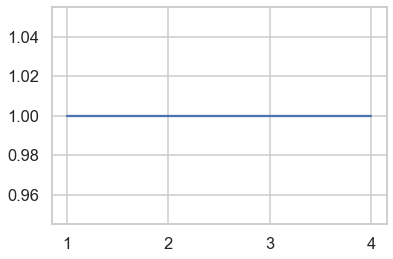

In [21]:
plt.plot(Accuracy['Depth'], Accuracy['Accuracy'])

In [22]:
print('It is showing a 100% hitrate, which means it estimate the the people whom might by a house to 100%')

It is showing a 100% hitrate, which means it estimate the the people whom might by a house to 100%


In [23]:
dt=DecisionTreeClassifier()

In [24]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [25]:
dt.score(X_test,y_test)

1.0

In [26]:
ypred=dt.predict(X_test)
confusion_matrix(y_test.values.argmax(axis=1), y_pred.argmax(axis=1),labels = labels)

array([[ 720,    0],
       [   0, 1266]])

### Knearest

In [27]:
### Standardizing Data because KNN uses the Euclidian distance to measure how close they are to each other
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test) 

In [28]:
from sklearn.neighbors import KNeighborsClassifier

In [29]:
accuracy_2 = []
n_b = range(1,10)

for i in n_b:
    pp = [1,2]
    for ii in pp:
        KNN = KNeighborsClassifier(n_neighbors=i,weights='distance', algorithm='auto',p=ii)
        KNN.fit(X_train_scaled, y_train)
        y_pred_2 = KNN.predict(X_test_scaled)
        confusion_matrix(y_test.values.argmax(axis=1), y_pred_2.argmax(axis=1),labels = labels)
        labels = np.unique(y_test)
        cm_1 = confusion_matrix(y_test.values.argmax(axis=1), y_pred_2.argmax(axis=1),labels = labels)
        acc = float(np.trace(cm_1)) / np.sum(cm_1)
        accuracy_2.append({'Kneihbors':i, 'Reguliser':ii,'Accuracy':acc})
    
Accuracy_1 = pd.DataFrame(accuracy_2)

In [30]:
Accuracy_1

,Accuracy,Kneihbors,Reguliser
0,0.994932,1,1
1,0.992890,1,2
2,0.994932,2,1
3,0.992890,2,2
4,0.993921,3,1
5,0.990821,3,2
6,0.994428,4,1
7,0.990858,4,2
8,0.993408,5,1
9,0.990326,5,2


In [31]:
reg1 = Accuracy_1.loc[Accuracy_1['Reguliser']==1]
reg2 = Accuracy_1.loc[Accuracy_1['Reguliser']==2]


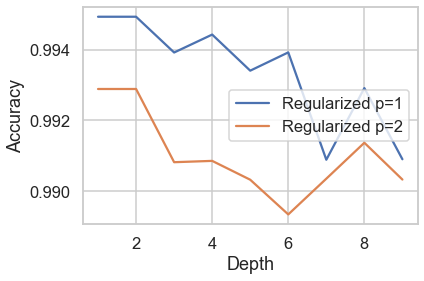

In [32]:
plt.plot(reg1['Kneihbors'], reg1['Accuracy'],label='Regularized p=1')
plt.plot(reg2['Kneihbors'],reg2['Accuracy'],label='Regularized p=2')
plt.xlabel('Depth')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Random Forest


The decision tree is the building block of a random forest, which therefore will obvious to test.

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf=RandomForestClassifier()
rf.fit(X_train, y_train)

print(f'Random Forest model Accuracy: {rf.score(X_test, y_test)}')

Random Forest model Accuracy: 1.0


/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning:

The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.



In [34]:
ypred_rf=rf.predict(X_test)

confusion_matrix(y_test.values.argmax(axis=1), ypred_rf.argmax(axis=1),labels = labels)

array([[ 720,    0],
       [   0, 1266]])

##  Logistic regression

In [35]:
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, precision_score

# function to evaluate predictions
def evaluate(y_true, y_pred):
    # calculate and display confusion matrix
    labels = np.unique(y_true)
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred)
    print('Confusion matrix\n- x-axis is true labels (none, comp1, etc.)\n- y-axis is predicted labels')
    print(cm)

    # calculate precision, recall, and F1 score
    accuracy = float(np.trace(cm)) / np.sum(cm)
    precision = precision_score(y_true.argmax(axis=1), y_pred, average=None, labels=labels)[1]
    recall = recall_score(y_true.argmax(axis=1), y_pred, average=None, labels=labels)[1]
    f1 = 2 * precision * recall / (precision + recall)
    print("accuracy:", accuracy)
    print("precision:", precision)
    print("recall:", recall)
    print("f1 score:", f1)

In [36]:
from sklearn.linear_model import LogisticRegression

# estimate model on trainset
model = LogisticRegression(random_state=42)
model.fit(X_train.values, np.argmax(y_train.values, axis=1))

# make predictions
y_pred_test = model.predict(X_test)
y_pred_train = model.predict(X_train)

# evaluate predictions
print("- Train set results:")
evaluate(y_train.values, y_pred_train)
print("- Test set results:")
evaluate(y_test.values, y_pred_test)

- Train set results:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[5027    0    0]
 [   2 5353  110]
 [   0  202 1965]]
accuracy: 0.9751955130737026
precision: 0.9636363636363636
recall: 0.9795059469350411
f1 score: 0.9715063520871143
- Test set results:
Confusion matrix
- x-axis is true labels (none, comp1, etc.)
- y-axis is predicted labels
[[ 720    0    0]
 [   1 1243   22]
 [   0   47  891]]
accuracy: 0.9760601915184679
precision: 0.9635658914728682
recall: 0.9818325434439179
f1 score: 0.9726134585289515


/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning:

Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.

/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning:

Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.



## Support Vector Machines

The support vector machine, which produces nonlinear boundaries by constructing a linear boundary in
a large, transformed version of the feature space. 

In [37]:
from sklearn.svm import SVC
sv=SVC()

In [38]:
sv.fit(X_train,y_train.values.argmax(axis=1))

/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [40]:
sv.score(X_test, y_test.values.argmax(axis=1))

1.0

In [42]:
ypred=sv.predict(X_test)

confusion_matrix(y_test.values.argmax(axis=1), ypred)

array([[ 720,    0,    0],
       [   0, 1266,    0],
       [   0,    0,  938]])

In [44]:
x_train_standard=(X_train-X_train.mean())/X_train.std()
x_test_standard=(X_test-X_test.mean())/X_test.std()

In [46]:
sv.fit(x_train_standard,y_train.values.argmax(axis=1))

/Users/AmeenaButt/anaconda3/envs/test/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [47]:
sv.score(x_test_standard, y_test.values.argmax(axis=1))

0.5560875512995896

In [49]:
ypred_standard=sv.predict(x_test_standard)
confusion_matrix(y_test.values.argmax(axis=1), ypred_standard)

array([[718,   1,   1],
       [737, 527,   2],
       [  0, 557, 381]])

# Exploratory Analysis

We want to look into finding the best neighborhood in Santiago to live in based on a low, middle and high monthly budgets. 

The monthly budget will look as following: 

- Low Standard: 9.000 - 13.000
- Middle standard: 13.000 - 17.000 
- High standard: 17.000 - 23.000 

*These budgets are estimated from the monthly dwelling rent.* 

The best house will be based on the neighborhood profile, which will be evaluated on the basis of the best:
- commute times 
- accessibility 
- monthly rent 
- condition of the house
- density
- income in the neighborhood

Lastly the different neighborhoods in Santiago (from above analysis) will be compared with lowest and highest living standard and the chances of finding the best house in the best zone.



In [2]:
data = pd.read_excel("Households Data.xlsx")
pd.set_option('display.max_columns', len(data.columns)+10)
print('Columns : ',data.columns)
print('Shape : ',data.shape)
data.head()

Columns :  Index(['Hogar', 'EXCLUIR', 'paraValidacion', 'Sector', 'DirCoordX',
       'DirCoordY', 'MontoArr', 'IngresoHogar', 'Factor', 'AnosEstudio',
       'CLASE', 'Sup_Prom_Constr_Hab_EOD', 'Calid_EOD_norm_inv',
       'DensConstr_EOD', 'Dist_est_Metro_MC_KM', 'Dist_salida_Autop_MC_KM',
       'Tiempo_Com_Stgo', 'Ingreso_Promedio_Zona_MM', 'Acc_Comercio_tpte_pub',
       'Acc_Educacion_tpte_pub', 'Acc_Habitacion_tpte_pub',
       'Acc_Industria_tpte_pub', 'Acc_Servicios_tpte_pub', 'Acc_Comercio_auto',
       'Acc_Educacion_auto', 'Acc_Habitacion_auto', 'Acc_Industria_auto',
       'Acc_Servicios_auto', 'CLUSTER7', 'CLUSTER2'],
      dtype='object')
Shape :  (18264, 30)


,Hogar,EXCLUIR,paraValidacion,Sector,DirCoordX,DirCoordY,MontoArr,IngresoHogar,Factor,AnosEstudio,CLASE,Sup_Prom_Constr_Hab_EOD,Calid_EOD_norm_inv,DensConstr_EOD,Dist_est_Metro_MC_KM,Dist_salida_Autop_MC_KM,Tiempo_Com_Stgo,Ingreso_Promedio_Zona_MM,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto,CLUSTER7,CLUSTER2
0,100010,0,0,7,335180.8019,6266420.975,100000,450845,136.393738,11,1,53.8,0.98,0.059,23.051711,4.345179,69,0.519765,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
1,100020,0,0,7,338410.2114,6265607.141,120000,1019369,73.843597,11,1,59.6,0.98,0.033,21.080177,1.381521,84,0.678317,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
2,100030,0,0,7,327863.8248,6257800.086,70000,80000,180.722809,10,1,59.5,0.98,0.004,34.147894,11.993389,83,0.408158,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
3,100041,0,0,7,327864.0000,6257800.000,80000,559259,150.379059,14,2,59.5,0.98,0.004,34.147817,11.993268,83,0.408158,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
4,100052,0,0,7,338480.8152,6267296.941,117771,710309,122.001518,12,2,43.6,0.98,0.086,19.908792,1.363177,94,0.498140,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1


In [3]:
#myProj = Proj("+proj=utm +zone=19 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs")
#data2 = data.copy(deep=True)
#lon, lat = myProj(data2['DirCoordX'].values, data2['DirCoordY'].values, inverse=True)

#data['Lat'] = lat
#data['Lon'] = lon
#print('Shape : ',data.shape)
#data.head()

In [4]:
#load data information of areas of Santiago 
#data_geo = gpd.read_file('ZonasEOD2012.shp')
#data_geo.tail()

In [5]:
#Converting the household data set to af geodataset to assign communes etc for the households
#geometry = [Point(xy) for xy in zip(data.DirCoordX, data.DirCoordY)]
#gdata = gpd.GeoDataFrame(data, geometry=geometry)
#gdata.tail()

In [6]:
#merging the geodata with the household data 
#data = gpd.sjoin(gdata, data_geo, how="inner", op='intersects')
#data = pd.DataFrame(data)
#data = data.drop(['index_right', 'geometry'], axis=1)
#data.head()

## Low Standard (90000-130000)
Below we have filtered houses which has low standards which is measured based on monthly dwelling rent spent in between `90000` to `130000`. Our analysis will be on rows which satisfy this criteria

In [7]:
data_low_standard = data[(data.MontoArr >= 90000) & (data.MontoArr <=130000)]
print('Low Standard : ',data_low_standard.shape)
data_low_standard.head()

Low Standard :  (5662, 30)


,Hogar,EXCLUIR,paraValidacion,Sector,DirCoordX,DirCoordY,MontoArr,IngresoHogar,Factor,AnosEstudio,CLASE,Sup_Prom_Constr_Hab_EOD,Calid_EOD_norm_inv,DensConstr_EOD,Dist_est_Metro_MC_KM,Dist_salida_Autop_MC_KM,Tiempo_Com_Stgo,Ingreso_Promedio_Zona_MM,Acc_Comercio_tpte_pub,Acc_Educacion_tpte_pub,Acc_Habitacion_tpte_pub,Acc_Industria_tpte_pub,Acc_Servicios_tpte_pub,Acc_Comercio_auto,Acc_Educacion_auto,Acc_Habitacion_auto,Acc_Industria_auto,Acc_Servicios_auto,CLUSTER7,CLUSTER2
0,100010,0,0,7,335180.8019,6266420.975,100000,450845,136.393738,11,1,53.8,0.98,0.059,23.051711,4.345179,69,0.519765,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
1,100020,0,0,7,338410.2114,6265607.141,120000,1019369,73.843597,11,1,59.6,0.98,0.033,21.080177,1.381521,84,0.678317,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
4,100052,0,0,7,338480.8152,6267296.941,117771,710309,122.001518,12,2,43.6,0.98,0.086,19.908792,1.363177,94,0.498140,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
5,100061,0,0,7,338520.4611,6267243.590,120000,415053,122.001518,9,1,43.6,0.98,0.086,19.912493,1.298621,94,0.498140,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1
6,100070,0,0,7,338672.2754,6267348.648,90000,231227,98.045624,15,2,43.6,0.98,0.086,19.728646,1.260107,94,0.498140,704.97642,406.0983,6110.62492,671.08681,719.84272,3036.41,1781.81,30505.65,2853.19,3058.03,3,1


### Plotting Average Built Surface of Residential Units Per Sector

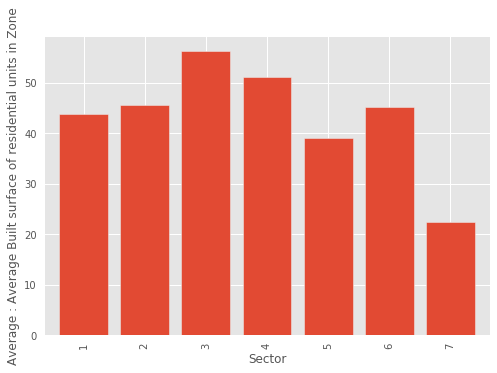

In [8]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['Sup_Prom_Constr_Hab_EOD']].plot(kind='bar', width=0.8)
    plt.ylabel('Average : %s'%'Average Built surface of residential units in Zone')
    plt.legend([],[])

From above graph we can see that `Sector 1,2,3,4 and 6` on average higher average built surface compared to other sectors. `Sector 5 and 7` has lower built surface compared to other sectors

### Plotting Average Construction Quality Per Sector

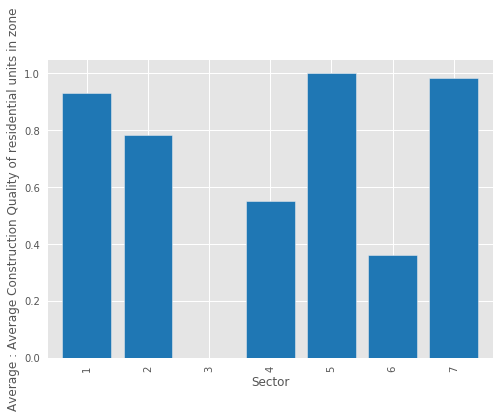

In [9]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['Calid_EOD_norm_inv']].plot(kind='bar', width=0.8, color='tab:blue')
    plt.ylabel('Average : %s'%'Average Construction Quality of residential units in zone')
    plt.legend([],[])

From abvoe plot we can see that `Sector 1,2,5,and 7` has good average construction quality compared to `Sector 3,4 and 6`
### Plotting Average Built Density Per Sector

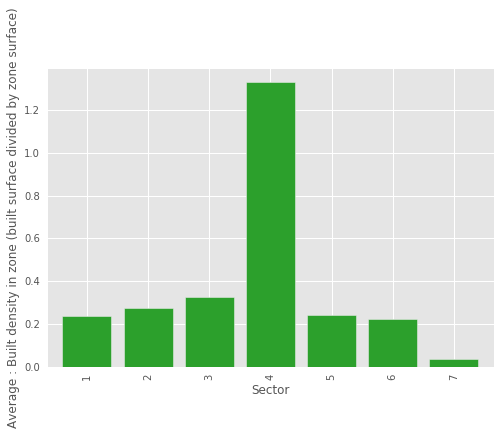

In [10]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['DensConstr_EOD']].plot(kind='bar', width=0.8, color='tab:green')
    plt.ylabel('Average : %s'%'Built density in zone (built surface divided by zone surface)')
    plt.legend([],[])

From above graph we can see that `Sector 4` has very hight average built density compared to other sectors. We can conclude that its very densely populated.

### Plotting Average Distance to Nearest Subway Station Per Sector

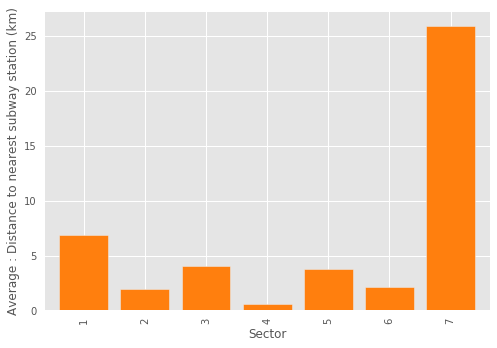

In [11]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['Dist_est_Metro_MC_KM']].plot(kind='bar', width=0.8, color='tab:orange')
    plt.ylabel('Average : %s'%'Distance to nearest subway station (km)')
    plt.legend([],[])

From above graphs we can see that `Sector 4` has least distance to nearest subway. We can see that other sectors such as `Sector 2 and 6` also has less distance. `Sector 7` has highest distance hence not recommended.


### Plotting Average Distance to Nearest Highway Exit Per Sector

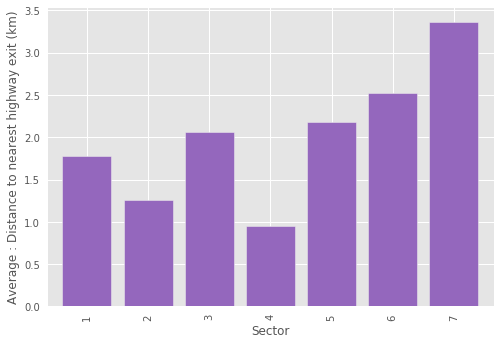

In [12]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['Dist_salida_Autop_MC_KM']].plot(kind='bar', width=0.8, color="tab:purple")
    plt.ylabel('Average : %s'%'Distance to nearest highway exit (km)')
    plt.legend([],[])

We can clearly see from above graph that `Sector 4` has least distance to nearest highway exist compared to other Sectors. `Sector 2` also has less distance like `Sector 4`. All other sectors has more distance compared to 2 and 4.

### Plotting Average Travel Time To CBD in Mins Per Sector

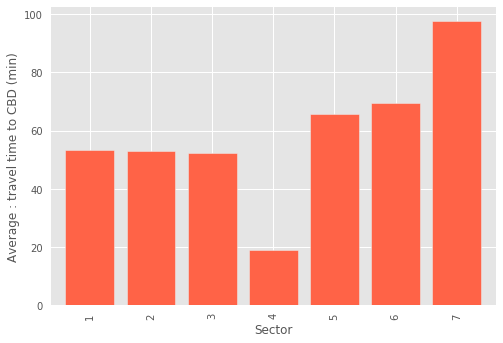

In [13]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['Tiempo_Com_Stgo']].plot(kind='bar', width=0.8, color='tomato')
    plt.ylabel('Average : %s'%'travel time to CBD (min)')
    plt.legend([],[])

We can see from above plot that `Sector 4` has quite low time to travel to CBD compared to other sectors. `Sector 1,2 and 3` has average 50 mins whereas ``

### Plotting Average Income Per Sector (Million Peso)

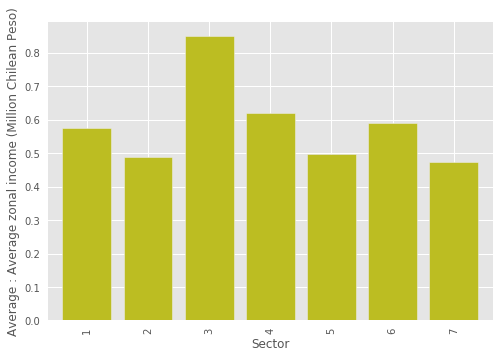

In [14]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['Ingreso_Promedio_Zona_MM']].plot(kind='bar', width=0.8, color='tab:olive')
    plt.ylabel('Average : %s'%'Average zonal income (Million Chilean Peso)')
    plt.legend([],[])

We can clearly see that average zonal income is highest for `Sector 3`. `Sector 1,4 and 6` has almost same income with `Sector 4` having little more. 

### Plotting Average Accesibility Variables Per Sector

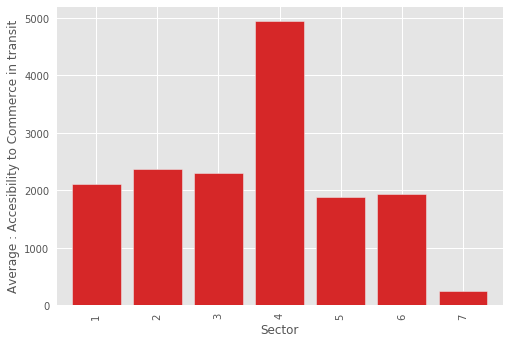

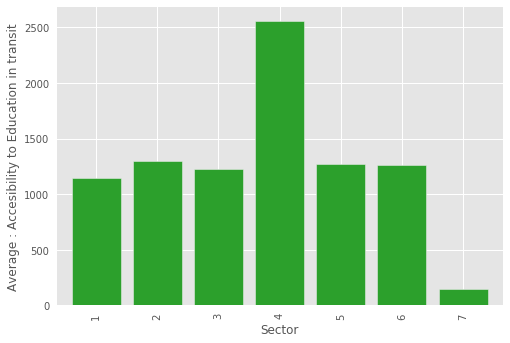

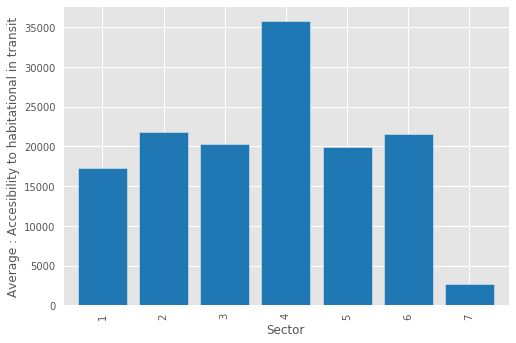

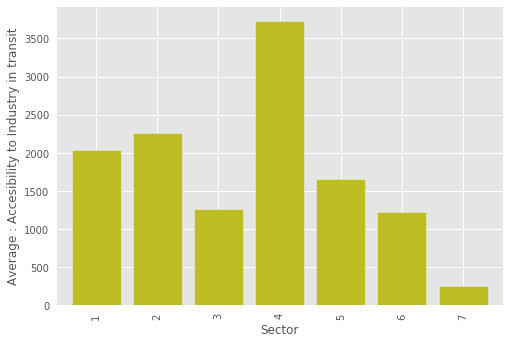

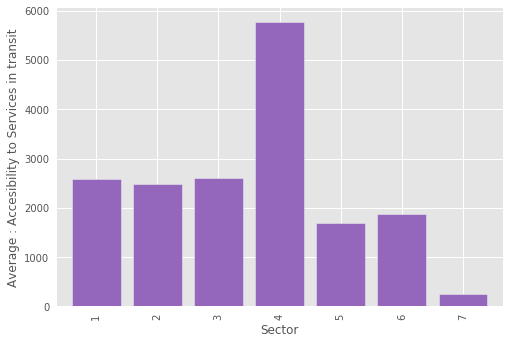

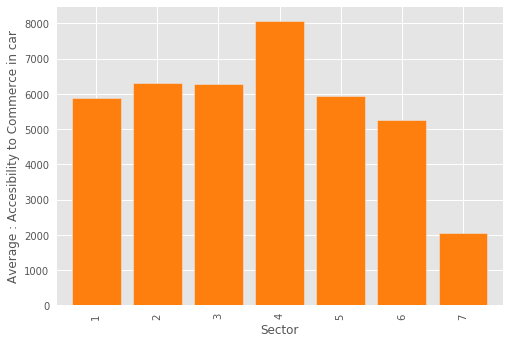

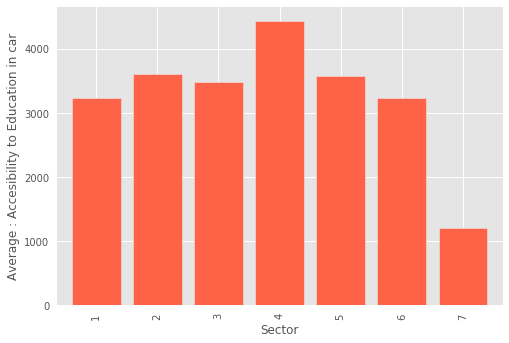

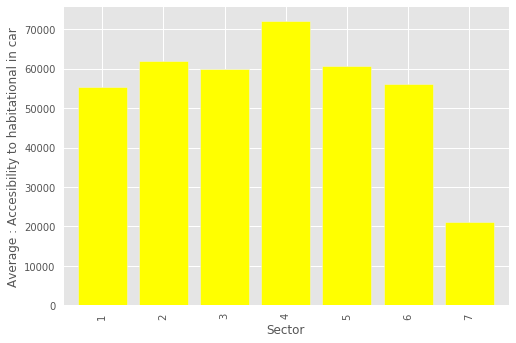

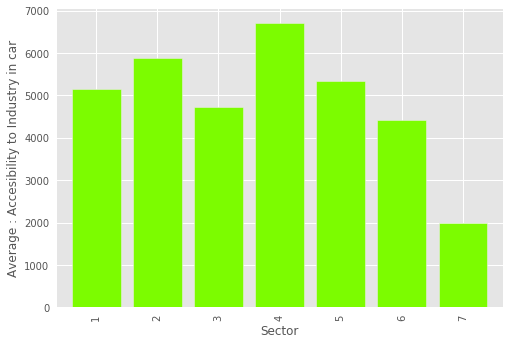

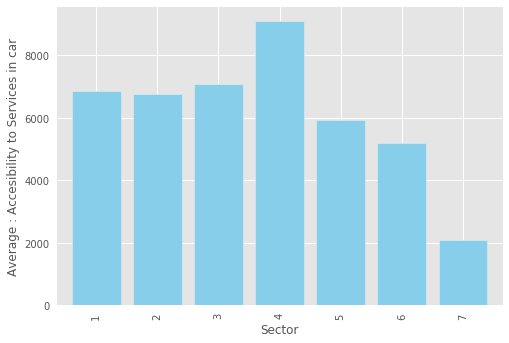

In [15]:
accessibility_cols = ['Acc_Comercio_tpte_pub',
                    'Acc_Educacion_tpte_pub',
                    'Acc_Habitacion_tpte_pub',
                    'Acc_Industria_tpte_pub',
                    'Acc_Servicios_tpte_pub',
                    'Acc_Comercio_auto',
                    'Acc_Educacion_auto',
                    'Acc_Habitacion_auto',
                    'Acc_Industria_auto',
                    'Acc_Servicios_auto'
]
accessibility_cols_descr = ['Accesibility to Commerce in transit',
              'Accesibility to Education in transit',
              'Accesibility to habitational in transit',
              'Accesibility to Industry in transit',
              'Accesibility to Services in transit',
              'Accesibility to Commerce in car',
              'Accesibility to Education in car',
              'Accesibility to habitational in car',
              'Accesibility to Industry in car',
              'Accesibility to Services in car']

colors = ['tab:red','tab:green','tab:blue', 'tab:olive', 'tab:purple', 'tab:orange', 'tomato','yellow', 'lawngreen','skyblue']
for i, col in enumerate(accessibility_cols):
    with plt.style.context(('seaborn', 'ggplot')):
        data_low_standard.groupby(by='Sector').mean()[[col]].plot(kind='bar', width=0.8, color=colors[i])
        plt.ylabel('Average : %s'%accessibility_cols_descr[i])
        plt.legend([],[])

From above graphs we can see that from accessibility point of view `Sector 4` is very accessible compared to other sectors.

### Calculating Households % which can afford staying in Sector 4

In [30]:
data_sector_4 = data_low_standard[data_low_standard.Sector == 4]
print('Average Rent in Sector 4 : %.2f'%data_sector_4.MontoArr.mean())
print('Average Income of Houshold in Sector 4 : %.2f'%data_sector_4.IngresoHogar.mean())
print('Total Households in Sector 4 : %d'%data_sector_4.shape[0])
income_more_than_rent = data_sector_4[data_sector_4.IngresoHogar >= data_sector_4.MontoArr].shape[0]
print('Total Households with Income more than Rent : %d'%income_more_than_rent)
print('%% of Houshold who can afford staying in Sector 4 : %.2f%%'%(income_more_than_rent*100/data_sector_4.shape[0]))
print('%% of Houshold who can not afford staying in Sector 4 : %.2f%%'%(100 - (income_more_than_rent*100/data_sector_4.shape[0])))

Average Rent in Sector 4 : 111340.43
Average Income of Houshold in Sector 4 : 418180.41
Total Households in Sector 4 : 94
Total Households with Income more than Rent : 85
% of Houshold who can afford staying in Sector 4 : 90.43%
% of Houshold who can not afford staying in Sector 4 : 9.57%


### Plotting Average Years of Formal Education Per Sector

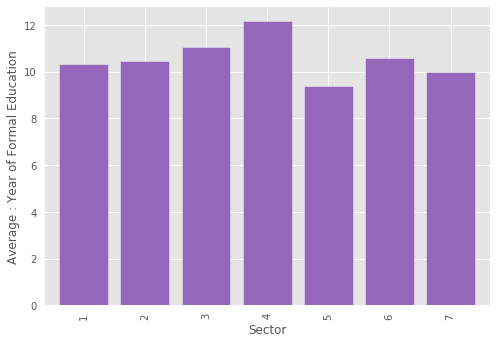

In [31]:
with plt.style.context(('seaborn', 'ggplot')):
    data_low_standard.groupby(by='Sector').mean()[['AnosEstudio']].plot(kind='bar', width=0.8, color='tab:purple')
    plt.ylabel('Average : %s'%'Year of Formal Education')
    plt.legend([],[])

We can clearly see from above graph that `Sector 4` people are clearly having more years(12+ years) of formal education that other sectors. `Sectors 1,2,3 and 6` also has average 10+ years of formal education. `Sector 5 and 7` seems to be lacking a bit but not that much.

### Plotting Location of Sectors on Map.
We are using below color coding scheme for representing each sector:
* `Red` - Sector 1
* `Green` - Sector 2
* `Blue` - Sector 3
* `White` - Sector 4
* `Olive` - Sector 5
* `Purple` - Sector 6
* `Orange` - Sector 7

In [2]:
data = pd.read_csv("CLEAN_HOUSEHOLD_DATASET (1).csv")
#data_sector_4 = data[data.Sector == 4]
#print('Sector 4 Entries in Cleaned CSV : %d'%data_sector_4.shape[0])
folium_map = folium.Map(location=[(data.Lat.min()+data.Lat.max())/2, (data.Lon.min()+data.Lon.max())/2],
                        zoom_start=10,
                        tiles="CartoDB dark_matter"
                        )

colors  = ['red', 'green', 'blue', 'white','olive','purple','orange']
for i in range(1,8):
    data_sector = data[data.Sector==i]
    for j in data_sector.index[:180]:
        folium.CircleMarker(location=(data_sector.loc[j]['Lat'], data_sector.loc[j]['Lon']),
                                radius=3.5,
                                color=colors[i-1],
                                popup=str(data_sector.loc[j]['Hogar']),
                                tooltip='Sector '+str(i)+' : '+ str(data_sector.loc[j]['Hogar']),
                                fill=True).add_to(folium_map)
folium_map

In [3]:
folium_map.save('sectors.html')

We can clearly see from above map that `Sector 4` is at the heart of Santiago.

## Conclusion:
We'll suggest `Sector 4` for `low Standard`.
- Average built surface is quite high compared to other sectors.
- Average consturction quality is low compared to other sectors.
- Average Density is quite high compared to other sectors
- Average distance to nearest subway is least compared to other sectors
- Average distance to nearest highway exit is also quite less
- Average travel time to nearest CBD is also quite less.
- Average income per sector is also more only lacking Sector 3 in that.
- From accesbility point of view, Highest accesibility to commerce, education, habitaional, industry and services in both transit and car. hence its very accesibile compared to other sectors.